In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import shap
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut
import lightgbm as lgb

## Read in data

In [80]:
data = pd.read_excel("../Converter/DATA_pKa_updated.xlsx")

In [81]:
data

,Unnamed: 0,Experiment,V (DMF),V (water),V(Acid),n (Acid),Acid pKa,ACID,Temperature,Time (h),%FA (w/w),SD,Acid_pKa
0,0,4_13,8,1.5600,0.38,0.004966,0.00,TFAA,60,3.0,0.099534,0.011640,0.00
1,1,4_13,8,0.8400,0.46,0.006011,0.00,TFAA,150,6.0,0.100667,0.010739,0.00
2,2,4_13,8,1.4096,1.14,0.013680,-6.30,HCl,100,9.0,0.340075,0.042111,-6.30
3,3,4_13,8,1.4800,0.06,0.001003,2.86,ClAA,100,24.0,0.030610,0.001769,2.86
4,4,4_13,8,3.4800,0.94,0.016450,4.75,AA,100,24.0,0.103782,0.023473,4.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,173,4_11,8,1.2800,1.00,0.012000,-6.30,HCl,120,72.0,0.424716,0.015782,-6.30
174,174,4_11,8,0.0640,0.10,0.001200,-6.30,HCl,120,168.0,0.065250,0.011350,-6.30
175,175,4_11,8,0.3200,0.50,0.006000,-6.30,HCl,120,168.0,0.365840,0.044320,-6.30
176,176,4_11,8,0.6400,1.00,0.012000,-6.30,HCl,120,168.0,0.495416,0.011728,-6.30


## Split data into features and labels

In [82]:
X = data[["V (water)", "n (Acid)", "Temperature ", "Time (h)", "Acid pKa"]]
y = data["%FA (w/w)"]
x = X.to_numpy(dtype='float')
y = y.to_numpy(dtype='float')

## Leave-one-out cross validation

In [83]:
loo = LeaveOneOut()
ytests = []
ypreds = []

params = {
    'objective': 'regression',  # Regression task
    'metric': 'l2',             # Mean Squared Error
    'num_leaves': 31,           # Number of leaves in each tree
    'learning_rate': 0.05,      # Learning rate
    'feature_fraction': 0.9,    # Feature fraction
    'bagging_fraction': 0.8,    # Bagging fraction
    'bagging_freq': 5,          # Frequency for bagging
    'verbose': -1,                # No output while training
    'early_stopping_round':100, 
}
num_round = 500
shap_list = []

for train_idx, test_idx in loo.split(X):
    X_train, X_test = x[train_idx], x[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    
    train_data = lgb.Dataset(X_train, label=y_train)
    test_data = lgb.Dataset(X_test, label=y_test)
    
    bst = lgb.train(params, train_data, num_round, valid_sets=[test_data])
    y_pred = bst.predict(X_test)
        
    ytests += list(y_test)
    ypreds += list(y_pred)
    explainer = shap.TreeExplainer(bst)
    shap_values = explainer.shap_values(X_test)
    shap_list.append(shap_values)
    
rr = metrics.r2_score(ytests, ypreds)
ms_error = metrics.mean_absolute_error(ytests, ypreds)
        
print("Leave One Out Cross Validation")
print("R^2: {:.3f}, MAE: {:.5f}".format(rr, ms_error))

Leave One Out Cross Validation
R^2: 0.727, MAE: 0.07412


## SHAP analysis

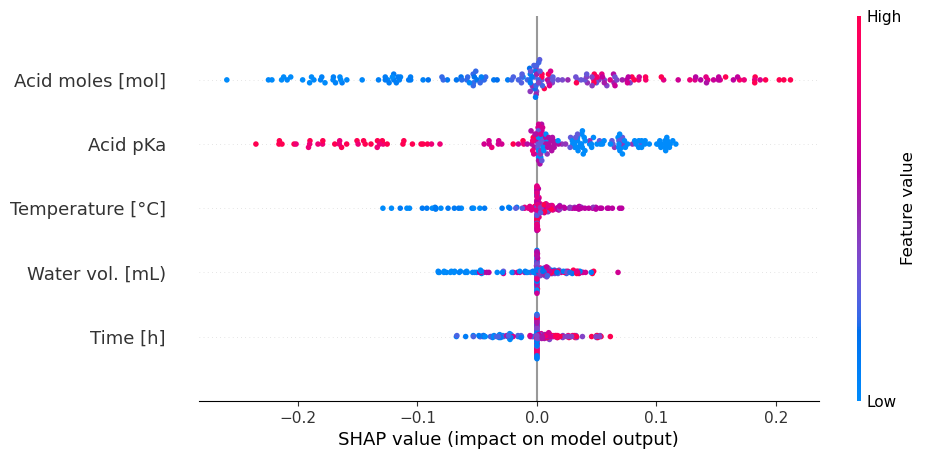

In [84]:
shap.summary_plot(np.array(shap_list).reshape(178, 5), x, 
                  plot_size=(10, 5), feature_names=["Water vol. [mL)", "Acid moles [mol]", "Temperature [°C]", "Time [h]", "Acid pKa"], 
                 color_bar_label='Feature value', show=False)

plt.gcf().axes[-1].set_aspect(100)
plt.gcf().axes[-1].set_box_aspect(100)
plt.savefig('shap_plot.png', bbox_inches='tight')

In [8]:
shap_values = np.vstack([sv[0] for sv in shap_list])
sv = np.abs(shap_values).mean(0)
std = np.std(shap_values)
importance_df = pd.DataFrame({
    "column_name": X.columns,
    "shap_values": sv,
    "std": std
})

importance_df = importance_df.sort_values(by=['shap_values'], ascending=False)

In [16]:
importance_df['column_name'].to_list()

['n (Acid)', 'Acid pKa', 'Temperature ', 'V (water)', 'Time (h)']

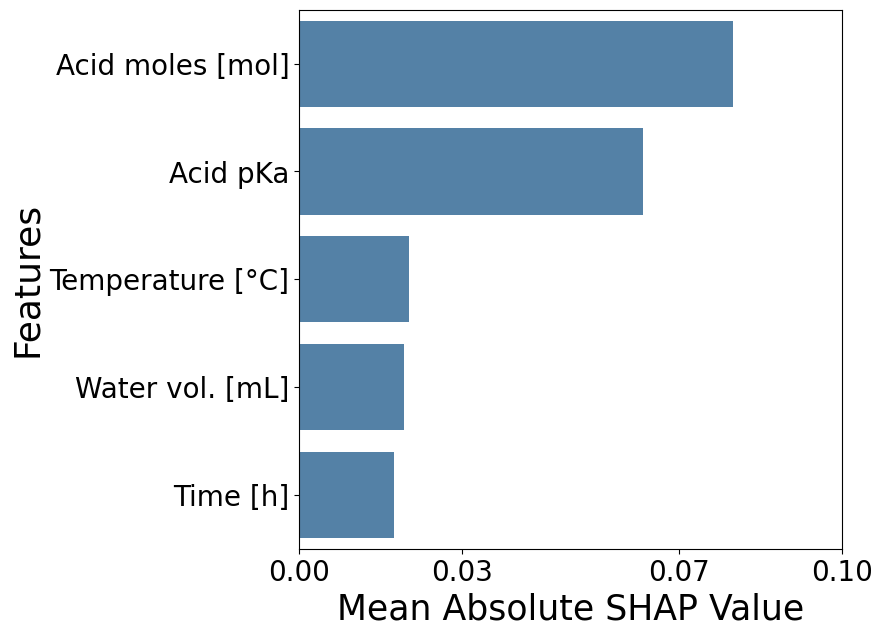

In [19]:
plt.figure(figsize=(7, 7))
sns.barplot(x=importance_df['shap_values'], 
            y=['Acid moles [mol]', 'Acid pKa', 'Temperature [°C]', 'Water vol. [mL]', 'Time [h]'],
            color='steelblue')
plt.xlabel('Mean Absolute SHAP Value', size=25)
plt.ylabel('Features', size=26)
plt.xticks(np.round(np.linspace(0, 0.1, 4), 2))
plt.xticks(size=20)
plt.yticks(size=20)
plt.savefig('mean_shap.png', bbox_inches='tight')

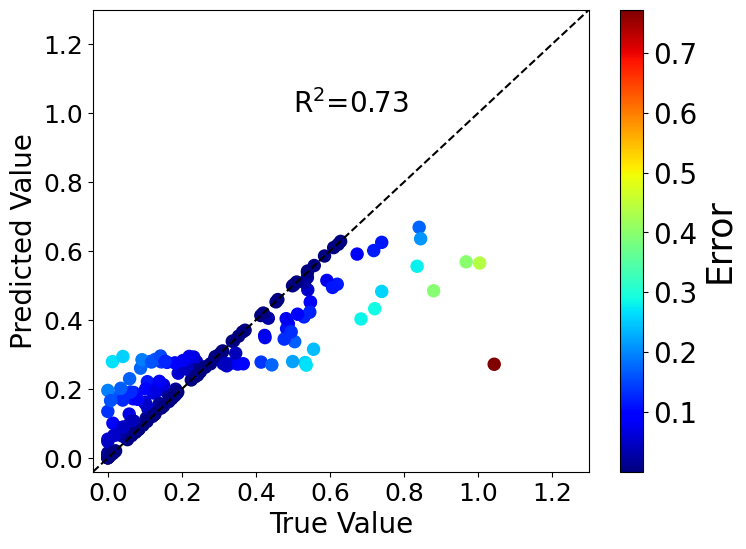

In [50]:
err = abs(np.array(ytests) - np.array(ypreds))

fig = plt.figure(figsize=(8, 6))

points = plt.scatter(ytests, ypreds, c=err, s=75, cmap="jet")

cbar = plt.colorbar(points)
cbar.set_label(label='Error', size=25) 
cbar.ax.tick_params(labelsize=20)

plt.xlabel('True Value', fontsize=20)
plt.ylabel('Predicted Value', fontsize=20)
plt.xticks(size=18)
plt.yticks(size=18)

plt.plot(np.linspace(-.04, 1.3, 10), np.linspace(-.04, 1.3, 10), '--', c='black')

plt.xlim([-.04, 1.3])
plt.ylim([-.04, 1.3])
plt.text(0.5, 1, f'R$^2$={round(rr, 2)}', size=20)
plt.savefig('reg_plt.png', bbox_inches='tight')

In [34]:
np.linspace(0, 1.2, 4)

array([0. , 0.4, 0.8, 1.2])

## Random Split

In [26]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)
    
bst = lgb.train(params, train_data, num_round, valid_sets=[test_data])
y_pred = bst.predict(X_test)

rr = metrics.r2_score(y_test, y_pred)
ms_error = metrics.mean_absolute_error(y_test, y_pred)
        
print("Random Split Stats.")
print("R^2: {:.3f}, MAE: {:.5f}".format(rr, ms_error))

Random Split Stats.
R^2: 0.518, MAE: 0.12344


## Y - Scrambling

In [53]:
# Split the dataset into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Train a LightGBM model on the original data
lgb_train = lgb.Dataset(X_train, Y_train)
lgb_test = lgb.Dataset(X_test, Y_test, reference=lgb_train)

params = {
    'objective': 'regression',
    'metric': 'l2',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'seed': 42
}

# Train on original Y
lgb_model = lgb.train(params, lgb_train, num_boost_round=100)

Y_pred = lgb_model.predict(X_test)
mse_original = metrics.mean_squared_error(Y_test, Y_pred)
r_original = metrics.r2_score(Y_test, Y_pred)
print(f"Original MSE: {mse_original}")

# Perform Y-scrambling
n_permutations = 100  # Number of times to scramble Y
mse_scrambled_list = []
r = []

for i in range(n_permutations):
    # Shuffle the target variable
    Y_train_scrambled = np.random.permutation(Y_train)

    # Train a new LightGBM model on the scrambled target
    lgb_train_scrambled = lgb.Dataset(X_train, Y_train_scrambled)
    lgb_model_scrambled = lgb.train(params, lgb_train_scrambled, num_boost_round=500)

    # Predict and evaluate
    Y_pred_scrambled = lgb_model_scrambled.predict(X_test)
    mse_scrambled = metrics.mean_squared_error(Y_test, Y_pred_scrambled)
    r.append(metrics.r2_score(Y_test, Y_pred_scrambled))
    mse_scrambled_list.append(mse_scrambled)

    print(f"Scrambled MSE [{i+1}/{n_permutations}]: {mse_scrambled}")

# Calculate and compare the performance with the scrambled target
mean_scrambled_mse = np.mean(mse_scrambled_list)
print(f"\nMean Scrambled MSE: {mean_scrambled_mse}")
print(f"Original MSE: {mse_original}")


Original MSE: 0.02530510653273267
Scrambled MSE [1/100]: 0.07330974213976044
Scrambled MSE [2/100]: 0.0647531015268047
Scrambled MSE [3/100]: 0.10135062957803263
Scrambled MSE [4/100]: 0.0768531673797925
Scrambled MSE [5/100]: 0.0682741781332124
Scrambled MSE [6/100]: 0.08659359440534302
Scrambled MSE [7/100]: 0.077248549651228
Scrambled MSE [8/100]: 0.0908134486059164
Scrambled MSE [9/100]: 0.09337591236963946
Scrambled MSE [10/100]: 0.0636046248240563
Scrambled MSE [11/100]: 0.10433249639063367
Scrambled MSE [12/100]: 0.08664442544313264
Scrambled MSE [13/100]: 0.09797319946115991
Scrambled MSE [14/100]: 0.09692513533728205
Scrambled MSE [15/100]: 0.07775289625345654
Scrambled MSE [16/100]: 0.10969304001411068
Scrambled MSE [17/100]: 0.09775546772191411
Scrambled MSE [18/100]: 0.05321394388386183
Scrambled MSE [19/100]: 0.10179146705045537
Scrambled MSE [20/100]: 0.07889819992850275
Scrambled MSE [21/100]: 0.10057891622566689
Scrambled MSE [22/100]: 0.12312711742677883
Scrambled MSE 

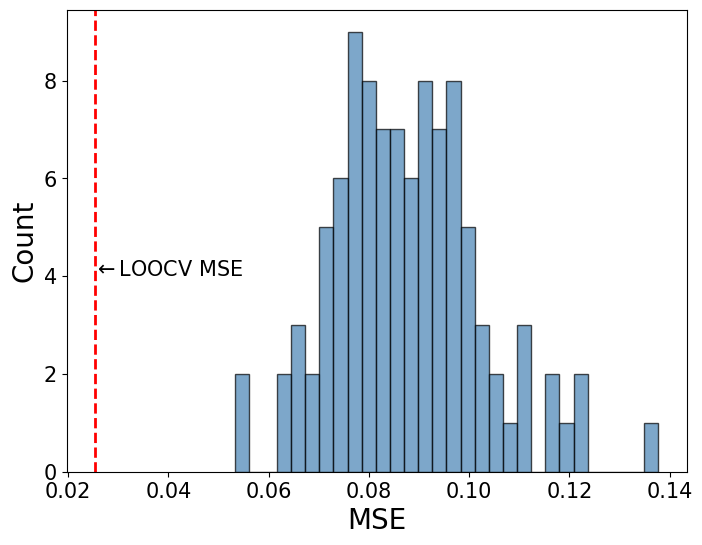

In [74]:
fig = plt.figure(figsize=(8, 6))

plt.hist(mse_scrambled_list, bins=30, color='steelblue', edgecolor='black', alpha=0.7)
plt.axvline(mse_original, color='red', linestyle='dashed', linewidth=2, label='Original MSE')

plt.text(x=0.025, y=4, s='$\leftarrow$LOOCV MSE', size=15)

plt.xlabel('MSE', size=20)
plt.ylabel('Count', size=20)

plt.xticks(size=15)
plt.yticks(size=15)
plt.savefig('Y_scramble_MSE.png', bbox_inches='tight')

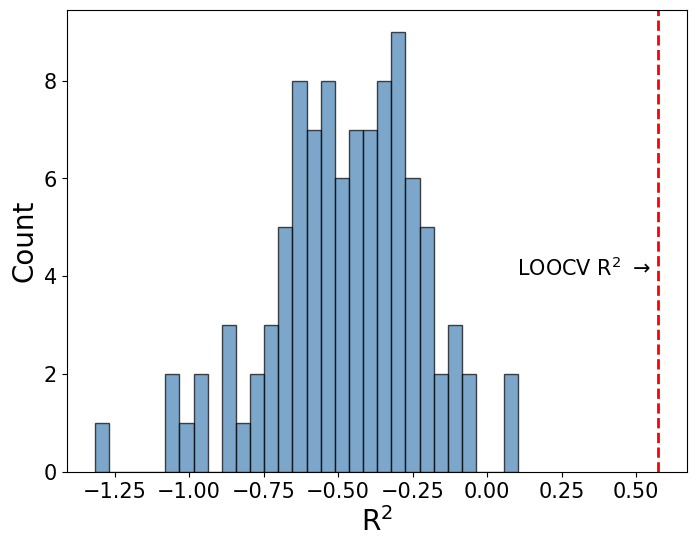

In [76]:
fig = plt.figure(figsize=(8, 6))

plt.hist(r, bins=30, color='steelblue', edgecolor='black', alpha=0.7)
plt.axvline(r_original, color='red', linestyle='dashed', linewidth=2, label='Original R$^2$')

plt.text(x=0.1, y=4, s=r'LOOCV R$^2$ $\rightarrow$', size=15)
plt.xlabel('R$^2$', size=20)
plt.ylabel('Count', size=20)

plt.xticks(size=15)
plt.yticks(size=15)
plt.savefig('Y_scramble_R2.png', bbox_inches='tight')

## SHAP values per input

In [68]:
shap_values = np.array(shap_list)

In [72]:
updated_labels = {
    'V (water)':'Water vol. [mL]',
    'n (Acid)': 'Acid moles [mol]',
    'Temperature ': 'Temperature [°C]',
    'Time (h)':  'Time [h]', 
    'Acid pKa': 'Acid pKa'
}


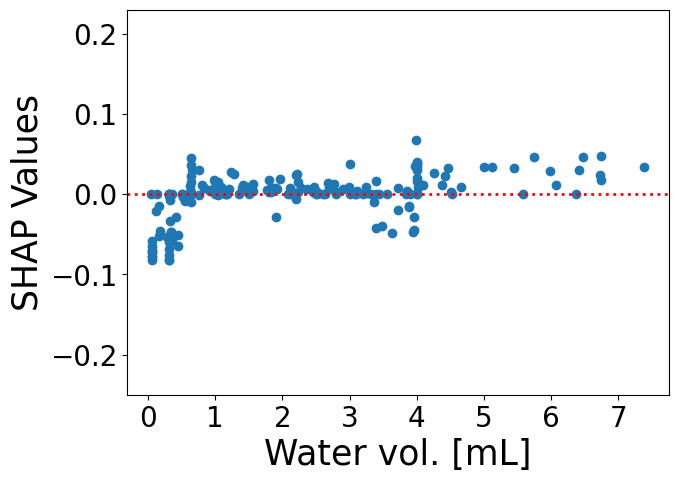

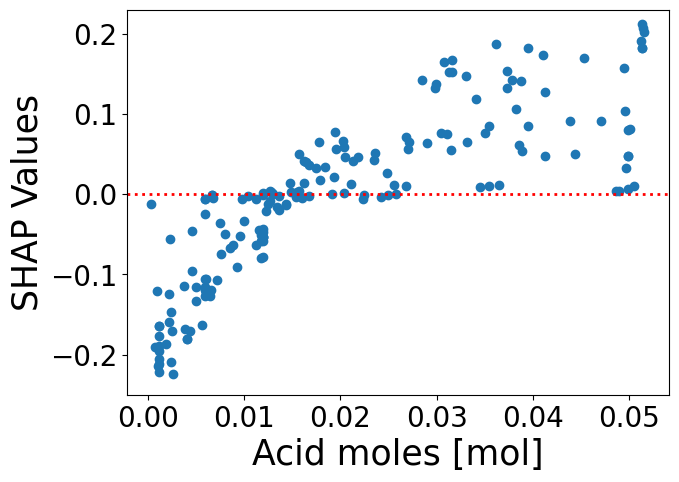

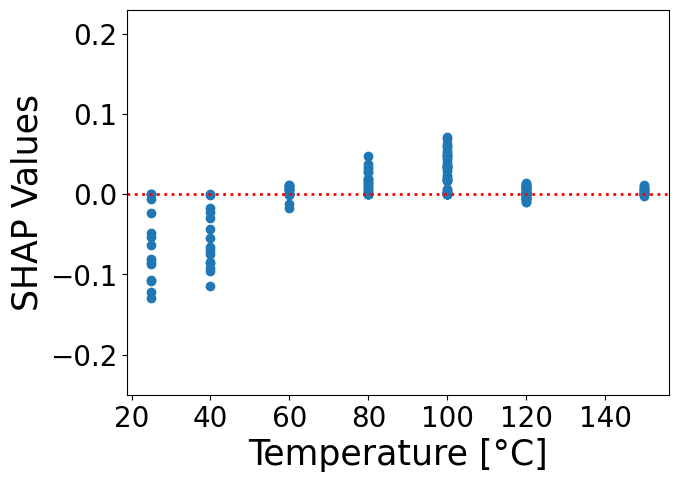

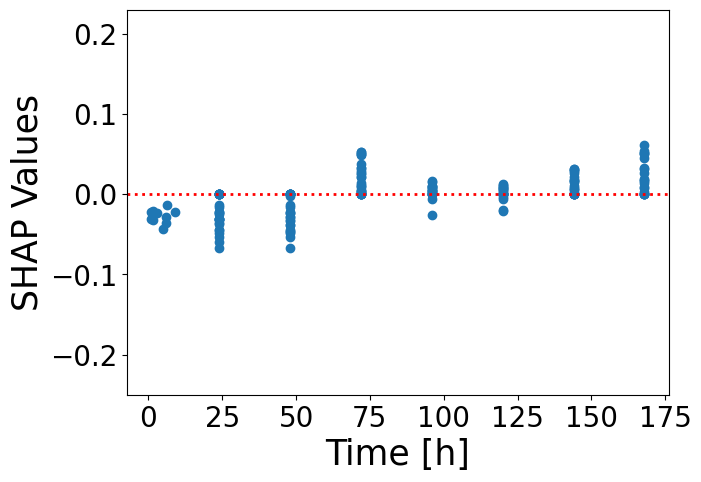

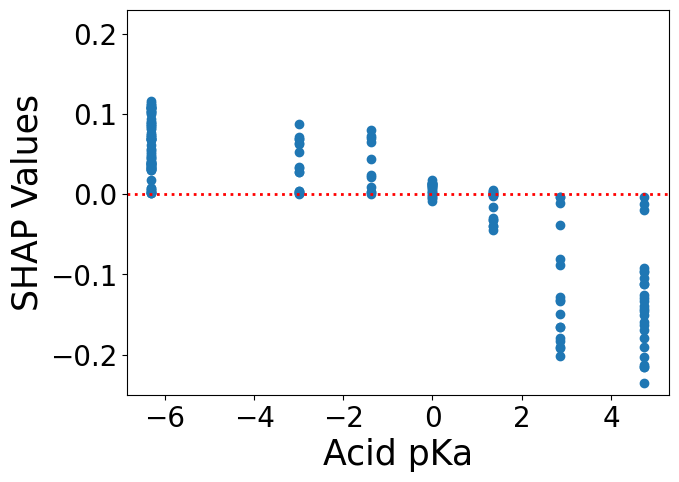

In [77]:
for label, shap, data in zip(X.columns, shap_values.T, x.T):
    fig = plt.figure(figsize=(7, 5))
    plt.scatter(data, shap)
    plt.axhline(y=0, color='r', linestyle=':', linewidth=2)
    plt.ylabel(f'SHAP Values', size=25)
    plt.xlabel(f'{updated_labels[label]}', size=25)
    plt.ylim([-0.25, 0.23])
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.savefig(f'shap_{label}.png', bbox_inches='tight')
    plt.show()